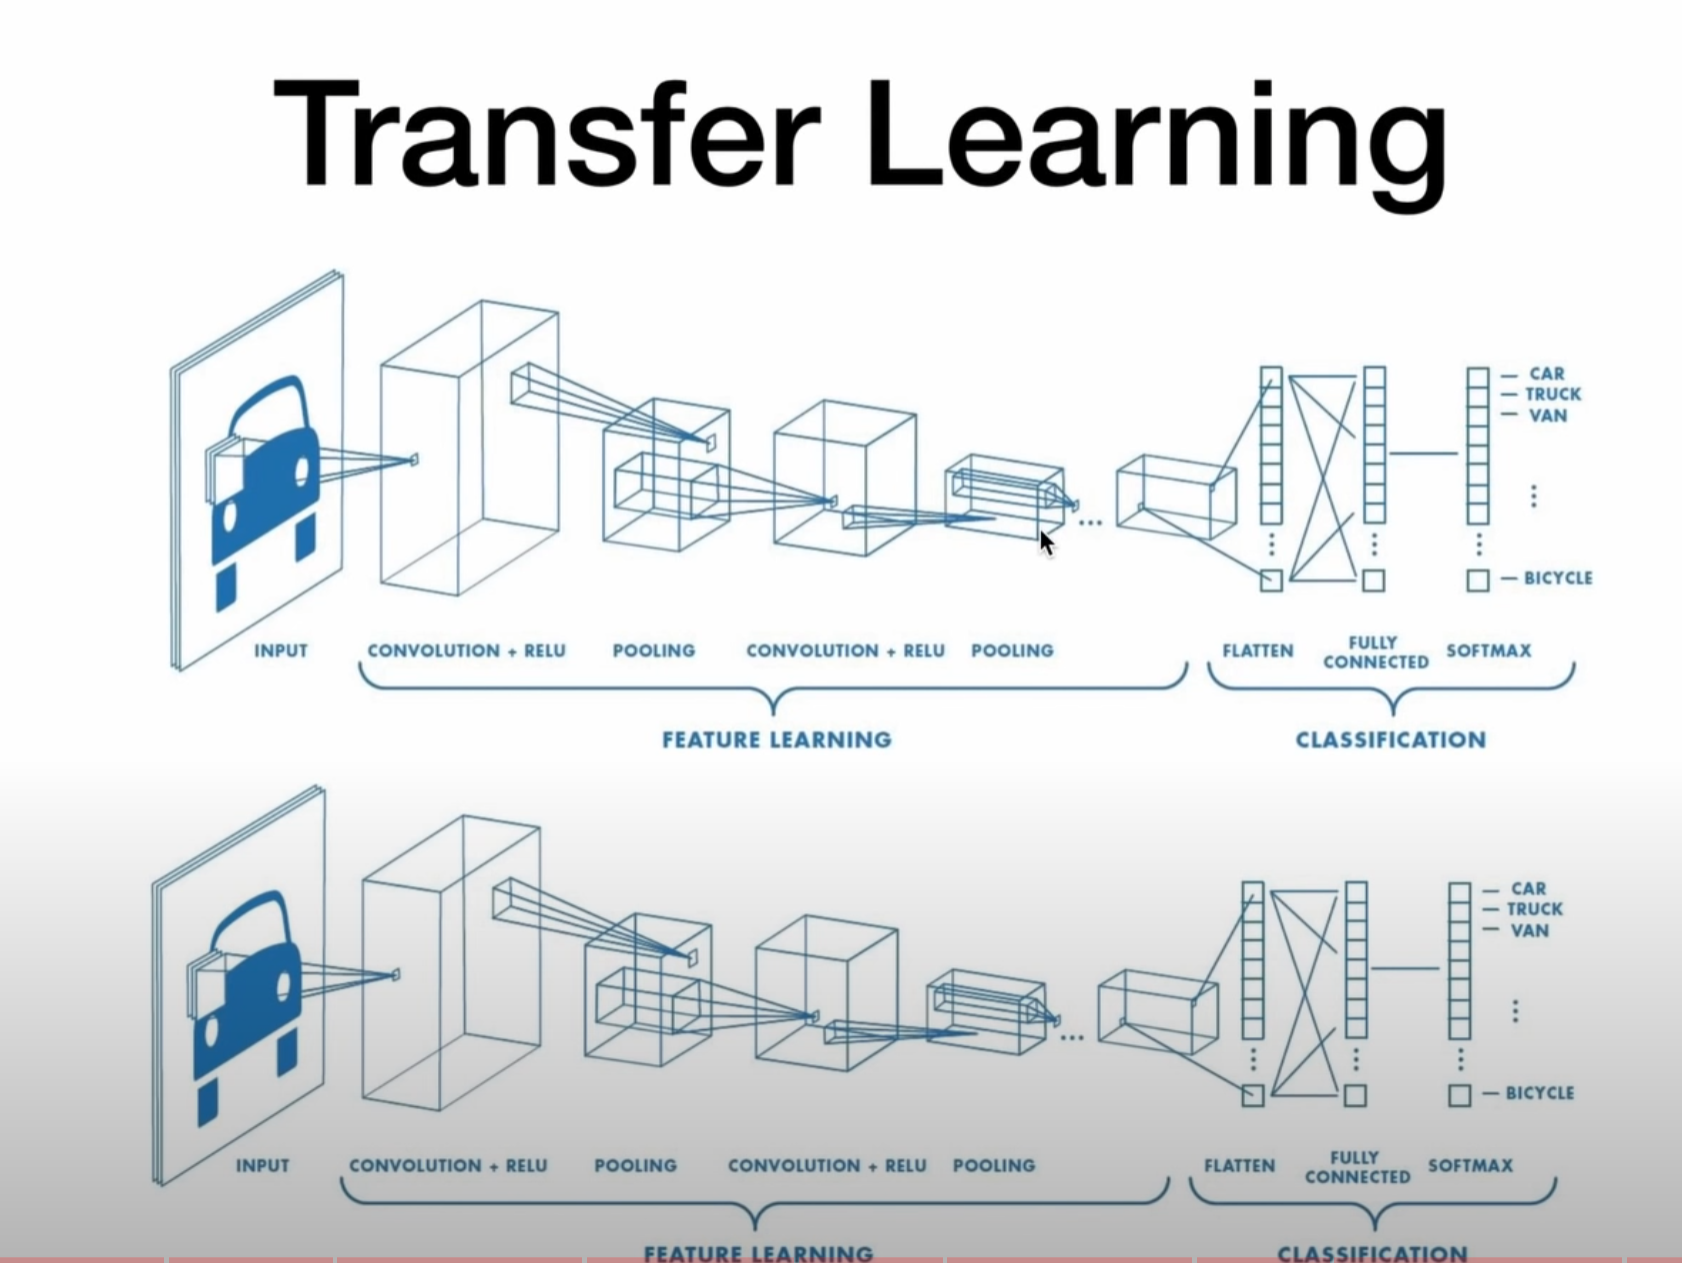

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets,models,transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ])
}

In [5]:
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

FileNotFoundError: ignored

In [ ]:
def train_model(model,criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      optimizer.zero_grad()
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          if phase == 'train':
              scheduler.step()

          epoch_loss = running_loss / dataset_sizes[phase]
          epoch_acc = running_corrects.double() / dataset_sizes[phase]

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
              phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

      print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model


In [ ]:
model = models.resnet18(pretrained=True) # already optimized
num_features = model.fc.in_features

In [ ]:
model.fc = nn.Linear(num_features, 2) #2 because 2 classes
model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
#Scheduler which will update learning rate

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7,gamma=0.1) #every 7 epochs our learning rate is multiplied by gamma (0.1)

In [ ]:
model = train_model(model,criterion, optimizer, step_lr_scheduler, num_epochs=20)

Alternative version to train very last layer (will be faster)

In [ ]:
model = models.resnet18(pretrained=True) # already optimized
for param in model.parameters():
  param.requires_grad = False # this will freeze all layers in the beginning
num_features = model.fc.in_features

In [ ]:
model.fc = nn.Linear(num_features, 2) #2 because 2 classes
model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
#Scheduler which will update learning rate

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7,gamma=0.1) #every 7 epochs our learning rate is multiplied by gamma (0.1)

In [ ]:
model = train_model(model,criterion, optimizer, scheduler, num_epochs=20)